In [2]:
import numpy as np
import heapq
from matplotlib import pyplot as plt
import skimage
from skimage import io

In [29]:
# Matrica so 8 redovi i 14 koloni (Sekoja kelija e kvadratce)
dimensions_world = (8, 14)

# Recnik koj gi sodrzi lokaciite i dimenziite na sekoja rabotna stanica
# KEY -> BROJKA KOJA JA IDENTIFIKUVA TAA RABOTNA STANICA (VIZUELNO PRETSTAVENA SO BOJA)
# VALUE -> NIZA OD TORKI - SEKOJA TORKA PRETSTAVUVA 
# EDNA KELIJA OD MATRICATA KOJA RABOTNATA STANICA JA ZAFAKA
area_workstation = {}

# Rabotna stanica 1 zafaka 4 kelii 
# (nulti red, prva kol),(prv red, prva kol),(nulti red, vtora kol),(prv red vtora kol)
area_workstation[1] = [(0, 1), (1, 1), (0, 2), (1, 2)]
# Slicno za site drugi rabotni stanici
area_workstation[2] = [(0, 5), (1, 5)]
area_workstation[3] = [(0, 11), (0, 12), (0, 13), (1, 11), (1, 12), (1, 13)]
area_workstation[4] = [(3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13)]
area_workstation[5] = [(7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9)]
area_workstation[6] = [(6, 13), (7, 13)]

In [4]:
# Funkcijata reset_world() ja postavuva inicijalnata sostojba na svetot:
def reset_world(dimensions_world, initial_agent_state):

    # 1. Najprvo sozdava matrica od nuli (data type int) so dimenzii na svetot
    world = np.zeros(dimensions_world, dtype=int) # world e -> 8x14 matrica
    
    for workstation_id, area in area_workstation.items():
    # area_workstation.items vraka niza od torki so 2 elementi:
    #   Element 1 -> Key na recnikot area_workstation (vo ovoj slucaj, identifikaciskiot broj na sekoja rabotna stanica: 1,2,3,...6)
    #   Element 2 -> Value na recniot area_workstation (vo ovoj slucaj, nizata od torki/dimenzii na sekoja rabotna stanica)
    
    #   Primer:
    #   Vo prvata iteracija na for ciklusot:
    #   workstation_id = 1
    #   area = [ (0, 1), (1, 1), (0, 2), (1, 2) ]
        for square in area:
            # Za sekoja kelija(torka) vo nizata area
            # Popolni ja taa kelija vo matricata world
            # so vrednosta na soodvetnata workstation_id

            #   Primer:
            #   - Veke znaeme deka workstation_id = 1
            #   - area = [ (0, 1), (1, 1), (0, 2), (1, 2) ]
            #       Vo prvata iteracija na for ciklusot:
            #       square = (0,1)
            #       pa matricata world, vo nultiot red, prvata kolona
            #       ke ja dobie vrednosta 1 (workstation_id)
            world[square] = workstation_id
    # Na kraj, pozicijata vo matricata na koja se naogja nasiot robot vo pocetnata sostojba
    # ja oznacuvame so 7
    
    world[initial_agent_state] = 7
    # Taka, sekoja od poziciite vo matricata se popolneti so brojka 0-7:
    # 0 - prazen prostor za dvizenje
    # 1-6 - rabotna stanica
    # 7 - robotot
    return world

# Funkcijata wisualise_world(), samo go prikazuva svetot na slika
# Na pocetokot, bidejki nemame pat, ke se prikaze pocetnata sostojba vo svetot
# No koga ke ja povikame funkcijava po zavrsuvanje na algoritmot za prebaruvanje, path nema da bide prazna promenliva
# pa na lokaciite vo path ke se nacrtaat beli kelii, oznacuvajki go patot koj 
# robotot treba da go odi, od negovata pocetna sostojba, do celta
def visualise_world(world, path=[]):
    # Iscrtuvanjeto na patot(ako go znaeme) go pravime so ovoj for ciklus
    for point in path:
        world[point] = 7

    # Potoa so paketot pyplot od bibliotekata matplotlib, go crtame ostatokot od svetot
    plt.rcParams['figure.figsize'] = [dimensions_world[1], dimensions_world[0]]
    plt.imshow(world, cmap=plt.cm.get_cmap('cubehelix', np.unique(world).size))
    plt.colorbar()
    plt.clim(-0.5, np.unique(world).size - 0.5)
    plt.xticks(np.arange(dimensions_world[1] + 1) - 0.5)
    plt.yticks(np.arange(dimensions_world[0] + 1) - 0.5)
    plt.grid()

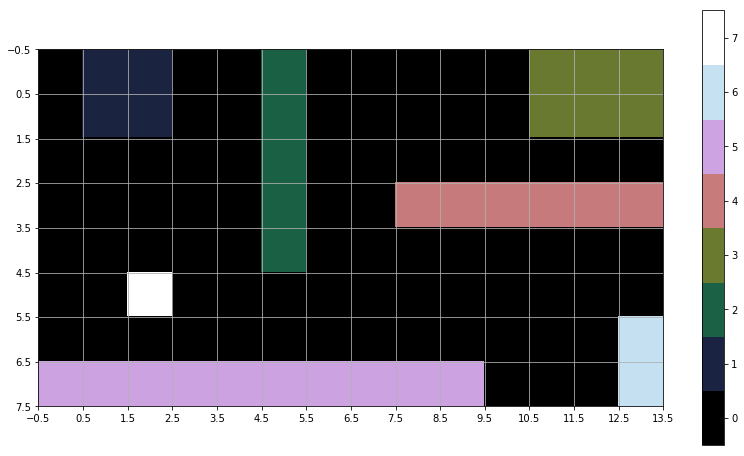

In [21]:
world = reset_world(dimensions_world, initial_agent_state=(5, 2))
visualise_world(world)


 # distance() funkcijata vraka evklidovo rastojanie sqrt( (x_1^2 - x_2^2) + (y_1^2 - y_2^2) )
def distance(agent_state, another_state):
    return np.sqrt((agent_state[0] - another_state[0])**2 + (agent_state[1] - another_state[1])**2)


def distance_ch(agent_state, another_state):
    delta_x = abs(agent_state[0] - another_state[0])
    delta_y = abs(agent_state[1] - another_state[1])
    return max(delta_x, delta_y)
    

In [26]:
 def filter_states(new_states):
    filtered_states = []
    for state in new_states:
        clean = True
        for a_id, area in area_workstation.items():
            if state in area:
                clean = False
        if clean:
            filtered_states.append(state)

          
    return filtered_states
 

# expand_state() funkcijata prima momentalna sostojba (torka so koordinati (i,j) od matricata)
# i gi generira site naredni sostojbi od taa:
# Praviloto za generiranje naredni sostojbi e:
#   - Robotot moze da se dvizi samo:
#       gore
#       dole
#       levo
#       desno
def expand_state(state_to_expand):

    i, j = state_to_expand

    new_states = []

    if i > 0:
        # Ako i(odnosno redot) > 0, znaci ne e zalepen do gorniot zid - moze da odi nagore, pa se dodava taa sostojba -> CEKOR GORE
        new_states.append((i - 1, j))
    if j > 0:
        # Ako j(odnosno kolonata) > 0, znaci ne e zalepen do leviot zid - moze da odi levo, pa se dodava taa sostojba -> CEKOR LEVO
        new_states.append((i, j - 1))
    if i < world.shape[0] - 1:
        # world.shape[0] go rava brojot na REDOVI vo matricata
        # world.shape[0] - 1 -> ja dava pozicijata na krajniot red (DOLNIOT ZID)
        # Ako i(odnosno redot) < DOLNIOT ZID, znaci ne e zalepen do dolniot zid - moze da odi dole,
        # pa se dodava taa sostojba -> CEKOR DOLE
        new_states.append((i + 1, j))
    if j < world.shape[1] - 1:
        # world.shape[1] go dava brojot na KOLONI vo matricata
        # world.shape[1] - 1 -> ja dava pozicijata na krajnata kolona (DESNIOT ZID)
        # Ako j(odnosno kolonata) < DESNIOT ZID, znaci ne e zalepen do desniot zid - moze da odi desno,
        # pa se dodava taa sostojba -> CEKOR DESNO
        new_states.append((i, j + 1))
    if i > 0 and j > 0:
        # Gore levo
        new_states.append((i - 1, j - 1))
    if i > 0 and j < world.shape[1] - 1:
        # Gore desno
        new_states.append((i - 1, j + 1))
    if i < world.shape[0] - 1 and j > 0:
        # Dole levo
        new_states.append((i + 1, j - 1))
    if i < world.shape[0] - 1 and j < world.shape[1] - 1:
        # Dole desno
        new_states.append((i + 1, j + 1))

    
    # print("NON FILTERED: ", new_states)
    new_states = filter_states(new_states)
    # print("FILTERED: ", new_states)
    # ************************************************* #
        # Najverojatno ovdeka ke treba da napravime funkcija
        # koja ke ja isfiltrira new_states nizata taka sto
        # ke se dodadat samo tie cekori(potezi, naredni sostojbi) koi se validni,
        # a validni ke bidat ako ne se lupa robotot vo rabotna stanica,
        # odnosno koordinatite na taa naredna sostojba ne se sofpagjaat so koordinatite na rabotna stanica
        # ************************************************** #
    return new_states


In [32]:
def a_star_search(initial_state, goal_state):
    alpha = 0.5
   
    expanded = set()
    
    # states_queue e lista od torki:
    # Sekoja torka e sostavena od 2 elementi:
    
    #   Element 1: torka sostavena od 2 elementi:
    #       - 1. tezinata spored A* algoritmot
    #       - 2. tezinata spored algoritmot so uniformna cena
    
    #   Element 2: lista od torki:
    #       sekoja torka pretstavuva edna kelija, a celata lista go pretstavuva patot do celta
    states_queue = [((0, 0), [initial_state])]
    heapq.heapify(states_queue)
    
    while states_queue:
        
        current_weight, states_list = heapq.heappop(states_queue)
        # states_list e patot
        current_a_star_weight, current_path_weight = current_weight
        
        state_to_expand = states_list[-1]

        # Test case
        if state_to_expand == goal_state:
            return states_list
        
        # Check if we've been here already
        if state_to_expand in expanded:
            continue

        for next_state in expand_state(state_to_expand):

            # Ova e presmetka na tezinata so uniformna cena:
            transition_weight = 1 # Cenata(tezinata) na premin od edna kelija do druga e 1
            # Ja dodavame taa tezina na momentalnata tezina so uniformna cena
            uniform_cost_weight = current_path_weight + transition_weight
            # Taka ja dobivame tezinata so uniformna cena na NEXT_STATE
            
            # Za da ja dobieme A* tezinata, pravime razlicna presmetka:
            # distance() funkcijata vraka evklidovo rastojanie megu dve tocki
            # toa rastojanie e evristickata tezina na NEXT_STATE
            heuristic_weight = distance(next_state, goal_state)

            # A* tezinata pretstavuva funkcija od EVRISTICKATA TEZINA i TEZINATA SO UNIFORMNA CENA
            #   ( (1 - alpha) * uniformna_tezina )    +    ( alpha * evristicka_tezina )
            a_star_weight = (1 - alpha) * uniform_cost_weight + alpha * heuristic_weight

            # Sega gi imame:
            #   - uniformnata tezina -> uniform_cost_weight
            #   - A* tezinata -> a_star_weight
            if next_state not in expanded:
                # Ako ja nemame razgraneto ovaa NEXT_STATE, ja dodavame vo heap-ot vo forma:
                # Torka so 2 elementi:
                # 1. torka od dvete tezini
                # 2. lista od dosegasniot pat
                #  ( (a*_tezina, uniformna_tezina), states_list + [next_state] )
                heapq.heappush(states_queue, ((a_star_weight, uniform_cost_weight), states_list + [next_state]))
        # Tuka zavrsuvame so razgranuvanjeto na momentalnata sostojba, i ja dodavame na mnozestvoto razgraneti sostojbi -> expanded
        expanded.add(state_to_expand)
    return []

[(5, 2), (4, 3), (3, 4), (2, 5), (1, 6), (1, 7)]


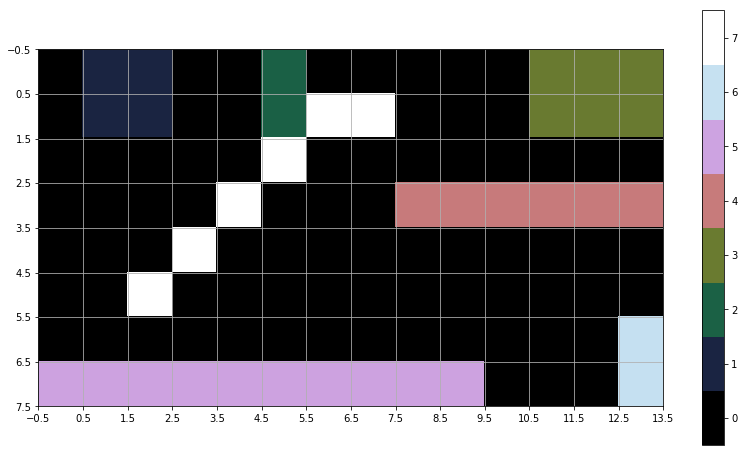

In [33]:
initial_state = (5, 2)
world = reset_world(dimensions_world, initial_agent_state=initial_state)
goal_state = (1, 7)
path = a_star_search(initial_state, goal_state)
print(path)
visualise_world(world, path)